In [71]:
import matplotlib.pyplot as plt

# from config import settings

import pymongo
%matplotlib inline


# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
db = pymongo.MongoClient("mongodb://localhost:27017/")['Aug25_macroblocks']


from joblib import Parallel, delayed, Memory


mem = Memory('/tank/kuntai/joblib_cache',verbose=0)


plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 35
plt.rcParams['pdf.fonttype'] = 42
colors = [
    '#004daf',
    '#ed1b3a',
    '#ff9900',
    '#33a02c',
    '#fabeaf',
    '#aad59b'
]
bandwidth = 10 * 1000 * 1000 / 8 # 10 Mbps
inference = 0.05
latency = 0.03 # 30ms network latency

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fig.savefig(f'{filename}_time_{timestr}.pdf', bbox_inches='tight')
    fig.savefig(f'{filename}.pdf', bbox_inches='tight')

In [36]:
@mem.cache
def single_query(query):
    x = list(db['examine'].find(query))
    x = sorted(x, key = lambda x: x['_id'])
    return x[-1]
    

@mem.cache
def query_approach(fmt, approach="", column='stats'):
    
    try:
        stats = []

        stats = Parallel(n_jobs=4,prefer='threads')(delayed(single_query)({
                'my_args.second': sec,
                'my_args.command_line_args.approach': approach,
                'my_args.input': fmt,
            }) for sec in range(0, 119))

        return np.mean([i['my_video_config']['bw'] for i in stats]), np.mean([i['f1'] for i in stats])
    except IndexError as e:
        print(fmt)
        print(approach)
        raise e



def query_approach2(fmt, approach="", column='stats'):
    
    try:
        stats = []

        stats = Parallel(n_jobs=4,prefer='threads')(delayed(single_query)({
                'my_args.second': sec,
                'my_args.command_line_args.approach': approach,
                'my_args.input': fmt,
            }) for sec in range(0, 119))

        return stats
    except IndexError as e:
        print(fmt)
        print(approach)
        raise e
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

EAAR done
DDS done
AccMPEG done


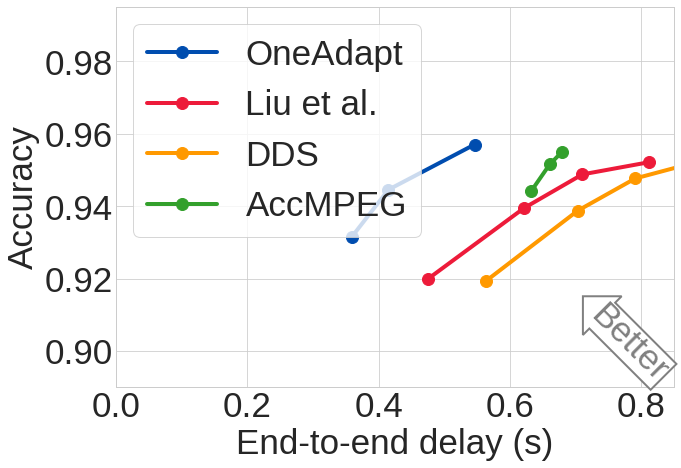

In [28]:


import numpy as np
fmt = '/dataheart/dataset/downtown/downtown_9/part%d.mp4'

fig, ax = plt.subplots(figsize=(10, 7))

# idxs = list(range(10))
# idxs = list(range(10))
idxs = [6]



x=[]
for thresh in [0.00625, 0.05, 0.2]:
    
    y = []

    
    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

        y.append(query_approach(fmt, f'oneadapt_macroblock_thresh_{thresh}'))
    y = np.array(y)

    x.append(np.mean(y, axis=0))

x = sorted(x, key = lambda i: i[0])
ax.plot([i[0]/bandwidth+inference+latency for i in x], [i[1] for i in x], label='OneAdapt', c=colors[0], marker='o', linewidth=4, markersize=12)




x = []
for lq in [32, 30, 28, 36]:

    y = []

    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f"eaar_lq_{lq}"))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
    
x = sorted(x, key = lambda i: i[0])
ax.plot([i[0]/bandwidth+inference+latency for i in x], [i[1] for i in x], label='Liu et al.', c=colors[1], marker='o', linewidth=4, markersize=12)

print('EAAR done')


x = []
for lq in [32, 30, 28, 36]:

    y = []

    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f"dds_lq_{lq}"))
    y = np.array(y)

    x.append(np.mean(y, axis=0))

x = sorted(x, key = lambda i: i[0])
ax.plot([i[0]/bandwidth+inference+latency+inference+latency for i in x], [i[1] for i in x], label='DDS', c=colors[2], marker='o', linewidth=4, markersize=12)

print("DDS done")


x = []
for lq in [42, 44, 50]:

    y = []
    thresh=0.15

    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f'accmpeg_thresh_{thresh}_lq_{lq}'))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
    
# 0.24: accmpeg processing delay
x = sorted(x, key = lambda i: i[0])
ax.plot([i[0]/bandwidth+inference+latency+0.24 for i in x], [i[1] for i in x], label='AccMPEG', c=colors[3], marker='o', linewidth=4, markersize=12)

print("AccMPEG done")


l, r = 0, 0.85
b, u = 0.89, 0.995

ax.set_xlim(l,r)
ax.set_ylim(b,u)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('End-to-end delay (s)')
ax.set_ylabel('Accuracy')
ax.set_yticks([0.9, 0.92, 0.94, 0.96, 0.98])

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props, c='grey')

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

ax.legend(loc=2,frameon=True)

In [12]:
savefig('/home/kuntai/paper/DiffAdapt-HotNets/figs/tradeoff-RGB-macroblocks', fig)

119
EAAR done


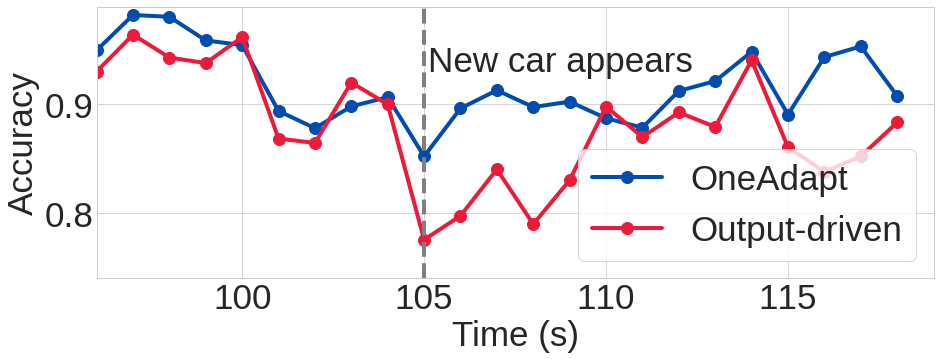

In [74]:


import numpy as np
fmt = '/dataheart/dataset/downtown/downtown_9/part%d.mp4'

fig, ax = plt.subplots(figsize=(15, 5))

# idxs = list(range(10))
# idxs = list(range(10))
idxs = [6]


x=[]
# for thresh in [0.00625, 0.05, 0.2]:
for thresh in [0.05]:
    
    y = []

    
    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

        x = query_approach2(fmt, f'oneadapt_macroblock_thresh_{thresh}')


print(len(x))
ax.plot(range(len(x)), [i['f1'] for i in x], label='OneAdapt', c=colors[0], marker='o', linewidth=4, markersize=12)




x = []
for lq in [36]:


    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        x = query_approach2(fmt, f"eaar_lq_{lq}")

ax.plot(range(len(x)), [i['f1'] for i in x], label='Output-driven', c=colors[1], marker='o', linewidth=4, markersize=12)

print('EAAR done')






# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')
ax.set_xlim(96, 119)
ax.set_ylim(0.74, 0.99)
# ax.set_yticks([0.9, 0.92, 0.94, 0.96, 0.98])

ax.axvline(x = 105, color = 'grey', linestyle='dashed', linewidth=4)
ax.text(105.1,0.93, 'New car appears',horizontalalignment='left')
# ax.axvline(x = 113, color = 'grey', linestyle='dashed', linewidth=4)
# ax.text(112.5,0.55, 'New car\nappears',horizontalalignment='right')

# bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
# t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
#             bbox=bbox_props, c='grey')

# bb = t.get_bbox_patch()
# bb.set_boxstyle("larrow", pad=0.05)

ax.legend(frameon=True)

In [70]:
savefig('/home/kuntai/paper/DiffAdapt-HotNets/figs/adaptation-RGB-macroblock', fig)